# 利用机器学习识别岩性

## 探索数据

首先，我们将检查将用于训练分类器的数据集。

数据集由七个特征（五个有线日志测量和两个指标变量）以及半英尺深度间隔的相位标记组成。
在机器学习的术语，在各深度间隔的测量值都包含一个特征向量，其与一个类别相关联。

In [12]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

In [2]:
training_data = pd.read_csv('data/facies_vectors.csv')
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


从表中我们可以看出，总共有4149个特征向量，每个特征向量含有如下的值：

1. Gamma ray (GR)
2. Resistivity (ILD_log10)
3. Photoelectric effect (PE)
4. Neutron-density porosity difference (DeltaPHI)
5. Average neutron-density porosity (PHIND)
6. Nonmarine/marine indicator (NM_M)
7. Relative position (RELPOS)

我们的数据集中含有9种不同的岩性类别。需要注意的是：不是所有的岩性都是严格分开的，`Adjacent facies` 栏包含了可能误分类的相关岩性编号。

| Facies | Description                | Label | Adjacent facies |
|:-------|:---------------------------|:------|:----------------|
| 1      | Nonmarine sandstone        | SS    | 2               |
| 2      | Nonmarine course siltstone | CSiS  | 1,3             |
| 3      | Nonmarine fine siltstone   | FSiS  | 2               |
| 4      | Marine siltstone and shale | SiSh  | 5               |
| 5      | Mudstone                   | MS    | 4,6             |
| 6      | Wackestone                 | WS    | 5,7,8           |
| 7      | Dolomite                   | D     | 6,8             |
| 8      | Packstone-grainstone       | PS    | 6,7,9           |
| 9      | Phylloid-algal bafflestone | BS    | 7,8             |


为了检测我们分类器的精度，我们从训练数据中移除一个测井，以便将预测数据和实际数据作比较。

In [3]:
blind = training_data[training_data['Well Name'] == 'SHANKLE']
training_data = training_data[training_data['Well Name'] != 'SHANKLE']

#  取出特征向量以及相关的岩性标签
# features = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
# features_vectors = data[features]
# facies_labels = data['Facies']
blind

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
937,2,A1 SH,SHANKLE,2774.5,98.36,0.642,-0.1,18.685,2.9,1,1.000
938,2,A1 SH,SHANKLE,2775.0,97.57,0.631,7.9,16.745,3.2,1,0.984
939,2,A1 SH,SHANKLE,2775.5,98.41,0.615,12.8,14.105,3.2,1,0.968
940,2,A1 SH,SHANKLE,2776.0,85.92,0.597,13.0,13.385,3.4,1,0.952
941,2,A1 SH,SHANKLE,2776.5,83.16,0.592,12.3,13.345,3.4,1,0.935
...,...,...,...,...,...,...,...,...,...,...,...
1381,8,C LM,SHANKLE,3006.0,32.84,1.120,-2.2,3.455,5.1,2,0.060
1382,8,C LM,SHANKLE,3006.5,25.16,1.112,-1.6,2.890,4.8,2,0.045
1383,8,C LM,SHANKLE,3007.0,25.16,1.112,-1.6,2.890,4.8,2,0.030
1384,4,C LM,SHANKLE,3007.5,26.22,1.092,-0.4,3.400,4.5,2,0.030


现在清洗数据，'Well Name'和'Formation'列可作为类别数据类型。

In [4]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

[SHRIMPLIN, ALEXANDER D, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (9, object): [SHRIMPLIN, ALEXANDER D, LUKE G U, KIMZEY A, ..., NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

这些即为用作训练集的10口测井名字。

可视化之前，先定义一些颜色来表示同的岩性，以便在所有的图中相同颜色都表示同样的岩性。还创建了缩写的岩性标签，并将其加入了facies_vectors 中。

In [5]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3700.000000,3700.000000,3700.000000,3700.000000,3700.000000,3700.000000,2783.000000,3700.000000,3700.000000
mean,4.615676,2908.853378,64.873649,0.663053,4.651677,12.892826,3.805693,1.540000,0.524125
std,2.475808,139.010855,30.817166,0.253863,5.109006,6.796219,0.894118,0.498465,0.287147
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2818.500000,43.778250,0.502000,1.800000,8.350000,3.200000,1.000000,0.278000
50%,4.000000,2939.000000,64.817000,0.645613,4.400000,11.857500,3.600000,2.000000,0.531000
75%,7.000000,3015.125000,80.322500,0.823000,7.600000,15.750000,4.400000,2.000000,0.772000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


这是输入数据的一个统计快照，通过 count 值可以看到有一些特征向量没有 PE 值。因此我们将这些特征向量丢掉。

In [6]:
PE_mask = training_data['PE'].notnull().values
training_data = training_data[PE_mask]

In [7]:
def make_facies_log_plot(logs, facies_colors):
    
    # make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
        facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: {}'.format(logs.iloc[0]['Well Name']), fontsize=14, y=0.94)

现在绘图查看测井 SHRIMPLIN 的 log

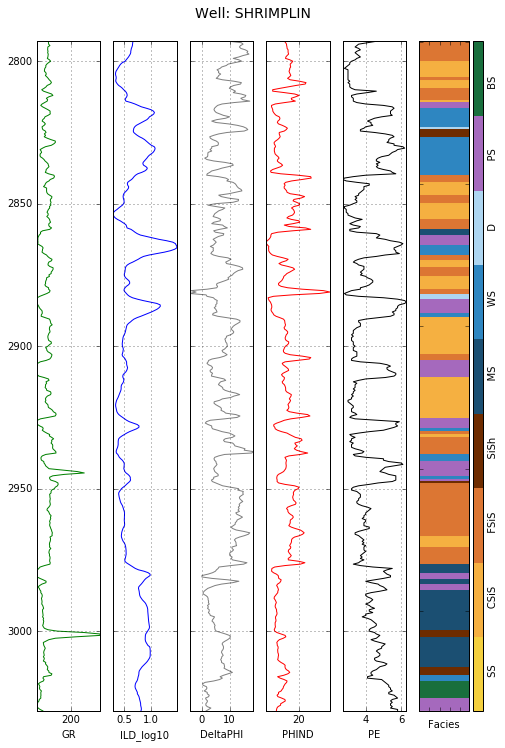

In [8]:
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

除了单独的测井，我们可以查看岩性在整个训练集中是如何表示的。下面我们绘制出每类岩性训练样本数的直方图。

SS      170
CSiS    649
FSiS    498
SiSh    177
MS      198
WS      391
D        81
PS      458
BS      161
Name: Facies, dtype: int64

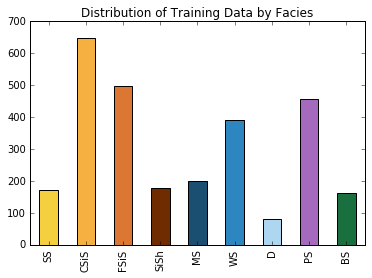

In [9]:
# Count the number of unique entries for each facies, sort them by
# facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()

# use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar', color=facies_colors,
                  title = 'Distribution of Training Data by Facies')

facies_counts

利用 `seaborn` 模块来可视化

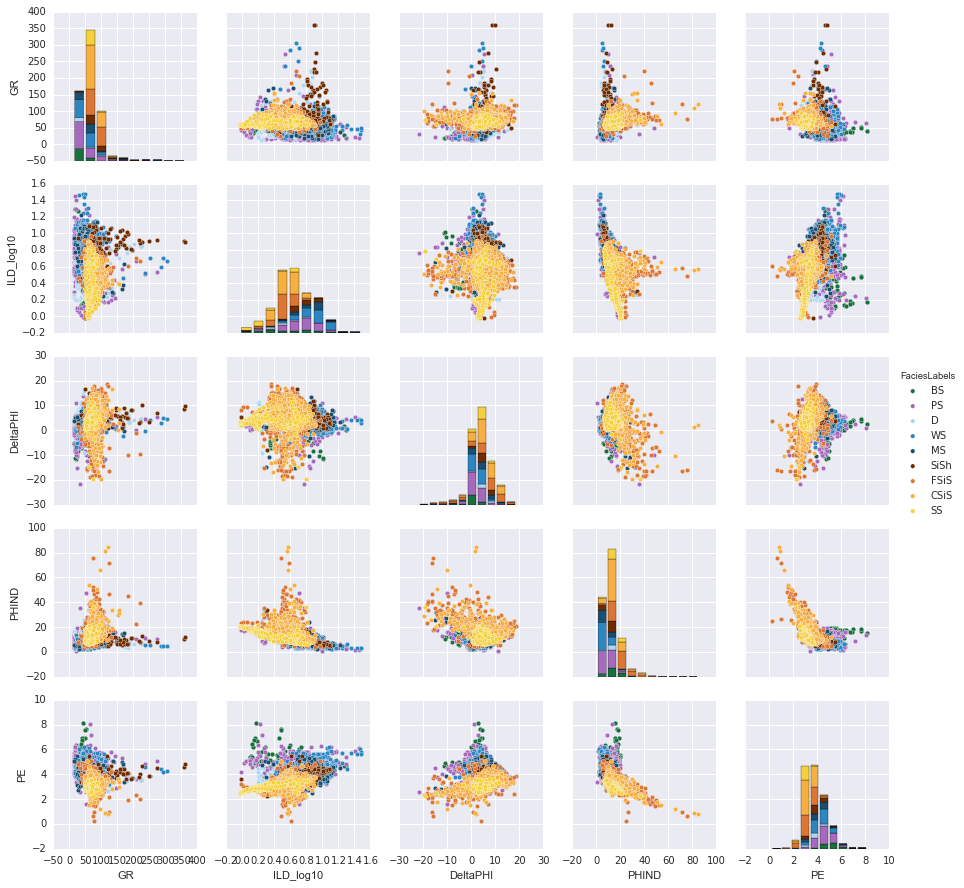

In [13]:
#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'], axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)